In [1]:
import os 
import glob
from pathlib import Path
import re 

audio_root_dir = Path(r'./Audio_Speech_Actors_01-24')
audio_file_pattern = Path(r'**/*.wav')

def get_emotion_label(filename):
    """
    For this project I'm using this dataset: The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)
    
    File naming convention

    Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier 
    (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

    Filename identifiers 

    Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    Vocal channel (01 = speech, 02 = song).
    Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    Repetition (01 = 1st repetition, 02 = 2nd repetition).
    Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
    
    Here we will only use 'Emotion' as the label for our training
    """
    EMOTION_LABEL_POS = 2 
    return int(re.findall(r"\d+", os.path.basename(filename))[EMOTION_LABEL_POS])

dataset is found at https://zenodo.org/record/1188976#.W2R6RtVKick

In [2]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display 
import numpy as np

# used for trimming spectrograms so that everything has the same shape 
MAX_FRAME_LIM = 150
MAX_FREQ_RANGE = 1000

SAMPLING_STRIDE = 10 

def get_spectrogram(audio_path):
    """
    return a downsampled spectrogram to save training time
    """
    samples, sample_rate = librosa.load(audio_file_path)
    full_spectrogram = librosa.amplitude_to_db(librosa.stft(samples), ref=np.max)
    return full_spectrogram[:MAX_FREQ_RANGE:SAMPLING_STRIDE, :MAX_FRAME_LIM, np.newaxis]

def display_spectrogram(spectrogram):
    CHANNEL = 0 # there's only one channel to display
    librosa.display.specshow(spectrogram[:, :, CHANNEL], y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Linear-frequency power spectrogram')
    

/Users/catherinehuang/Desktop/CS/python/text_sentiment_analysis/sentiment_analysis_venv/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


(100, 150, 1)


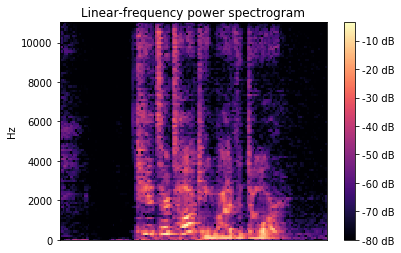

In [3]:
audio_file_path = 'Audio_Speech_Actors_01-24/Actor_07/03-01-01-01-01-02-07.wav'

spectrogram = get_spectrogram(audio_file_path)
print(spectrogram.shape)
display_spectrogram(spectrogram)

In [4]:
spectrograms = []
labels = []

# takes about 6-8 min on my machine
for audio_file in glob.iglob(str(audio_root_dir / audio_file_pattern), recursive=True):
    spectrograms.append(get_spectrogram(audio_file))
    labels.append(get_emotion_label(audio_file))

/Users/catherinehuang/Desktop/CS/python/text_sentiment_analysis/sentiment_analysis_venv/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [5]:
len(labels)

1440

In [6]:
spectrograms = np.array(spectrograms)
labels = np.array(labels)

In [7]:
spectrograms.shape

(1440, 100, 150, 1)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(spectrograms, labels, test_size=0.4, random_state=0)
X_train.shape

(864, 100, 150, 1)

In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

In [10]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    _, height, width, _ = features.shape
    height, width = int(height), int(width)
    
    kernel_size=[5, 5]
    
    strides = 5
    pool_size = [5, 5]
    
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=features,
      filters=32,
      kernel_size=kernel_size,
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=pool_size, strides=strides)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2_filters = 64
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=conv2_filters,
      kernel_size=kernel_size,
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=pool_size, strides=strides)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, 
                            [-1, (height // (strides ** 2)) * (width // (strides ** 2)) * conv2_filters])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [14]:
# Create the Estimator
emotion_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/audio_cnn_model")

# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=100)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/audio_cnn_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12b8958d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_train,
    y=y_train,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
emotion_classifier.train(
    input_fn=train_input_fn,
    steps=5000,
    hooks=[logging_hook])

In [16]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_test,
    y=y_test,
    num_epochs=1,
    shuffle=False)
eval_results = emotion_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-09-02:38:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/audio_cnn_model/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-09-02:38:53
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.119791664, global_step = 5000, loss = 2.081979
{'accuracy': 0.119791664, 'loss': 2.081979, 'global_step': 5000}


Train for a further 15000 steps (~8hrs)

In [ ]:
emotion_classifier.train(
    input_fn=train_input_fn,
    steps=15000,
    hooks=[logging_hook])

In [ ]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_test,
    y=y_test,
    num_epochs=1,
    shuffle=False)
eval_results = emotion_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)